# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [1]:
# - Importe De Librerías:

import requests
from bs4 import BeautifulSoup
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import io

In [2]:
# - Obtención del estatus HTML:

url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"
response = requests.get(url)

# - Verificación de respuesta:

print("Estado:", response.status_code)

if response.status_code != 200:
    raise Exception("Error al obtener la página")

Estado: 200


In [3]:
# - Extracción de tablas HTML con Pandas:

html = io.StringIO(response.text)
tables = pd.read_html(html)
print(f"Se encontraron {len(tables)} tablas.")

# - Selección y limpieza de la tabla correcta:

df = tables[0]  # Extrae la primera tabla
df.columns = ["Rank", "Song", "Artist", "Streams (billions)", "Date released", "Reference"]

# - Eliminación de notas entre corchetes en 'Song' y 'Artist':

df["Song"] = df["Song"].str.replace(r"\[.*?\]", "", regex=True)
df["Artist"] = df["Artist"].str.replace(r"\[.*?\]", "", regex=True)

# - Filtrado de datos correctos en 'Streams (billions)':

df = df[df["Streams (billions)"].astype(str).str.contains(r"^\d+(\.\d+)?$", na=False)].copy()

# - Conversión de columnas a tipos apropiados:

df["Streams (billions)"] = df["Streams (billions)"].astype(float)
df["Date released"] = pd.to_datetime(df["Date released"], errors="coerce")

# - Creación de Base de Datos SQLite:

with sqlite3.connect("spotify_top_songs.db") as conn:
    df.to_sql("most_streamed", conn, if_exists="replace", index=False)
    cursor = conn.cursor()
    cursor.execute("SELECT COUNT(*) FROM most_streamed")
    print("Rows inserted:", cursor.fetchone()[0])

Se encontraron 27 tablas.
Rows inserted: 100


/tmp/ipykernel_5503/3328195297.py:19: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[df["Streams (billions)"].astype(str).str.contains(r"^\d+(\.\d+)?$", na=False)].copy()


/tmp/ipykernel_5503/3411241244.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x="Streams (billions)", y="Song", palette="viridis", legend=False)
/tmp/ipykernel_5503/3411241244.py:12: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspaces/4Geeks-12-Web-Scraping-Project-Tutorial/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


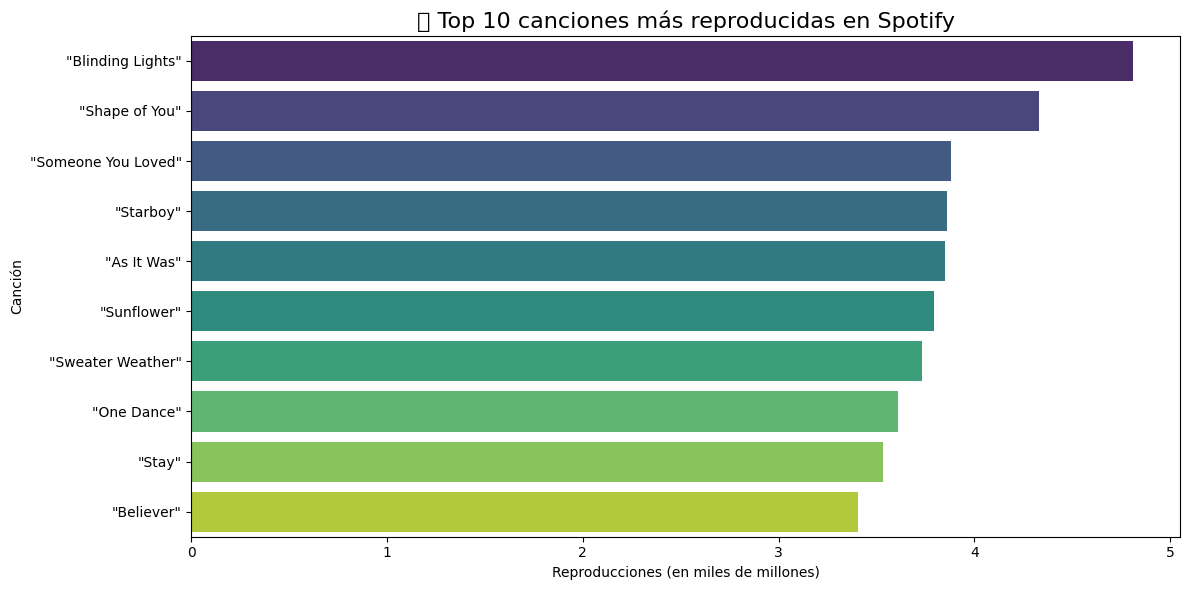

/tmp/ipykernel_5503/3411241244.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Year", order=sorted(df["Year"].dropna().unique()), palette="magma")
/tmp/ipykernel_5503/3411241244.py:25: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspaces/4Geeks-12-Web-Scraping-Project-Tutorial/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


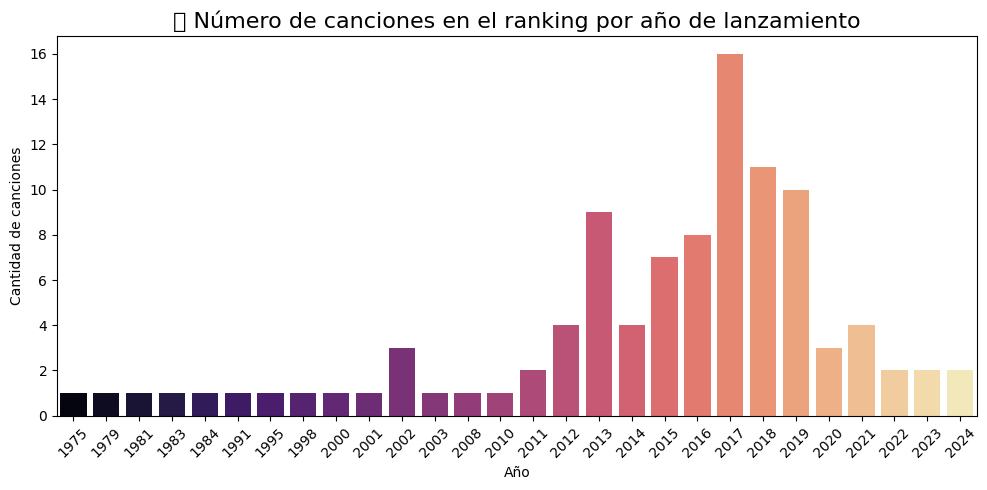

/tmp/ipykernel_5503/3411241244.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=artists.values, y=artists.index, palette="coolwarm", legend=False)
/tmp/ipykernel_5503/3411241244.py:37: UserWarning: Glyph 127908 (\N{MICROPHONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspaces/4Geeks-12-Web-Scraping-Project-Tutorial/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127908 (\N{MICROPHONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


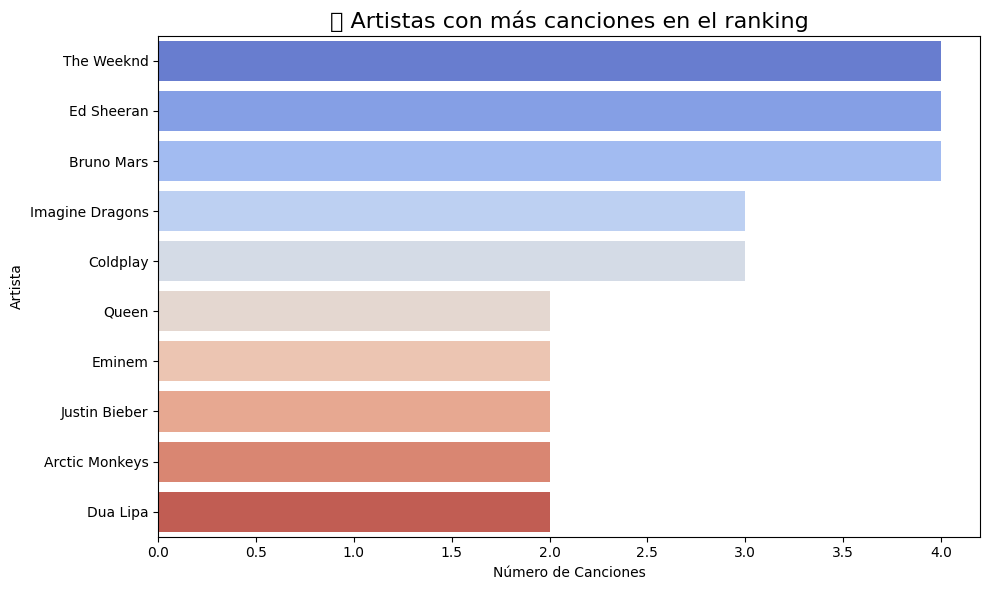

In [4]:
# - Gráficos de Análisis:

# - Top 10 canciones más reproducidas:

top10 = df.nlargest(10, "Streams (billions)")

plt.figure(figsize=(12, 6))
sns.barplot(data=top10, x="Streams (billions)", y="Song", palette="viridis", legend=False)
plt.title("🎵 Top 10 canciones más reproducidas en Spotify", fontsize=16)
plt.xlabel("Reproducciones (en miles de millones)")
plt.ylabel("Canción")
plt.tight_layout()
plt.show()

# - Número de canciones por año de lanzamiento:

df["Year"] = df["Date released"].dt.year

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="Year", order=sorted(df["Year"].dropna().unique()), palette="magma")
plt.title("📅 Número de canciones en el ranking por año de lanzamiento", fontsize=16)
plt.xlabel("Año")
plt.ylabel("Cantidad de canciones")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# - Artistas con más canciones en el ranking:

artists = df["Artist"].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=artists.values, y=artists.index, palette="coolwarm", legend=False)
plt.title("🎤 Artistas con más canciones en el ranking", fontsize=16)
plt.xlabel("Número de Canciones")
plt.ylabel("Artista")
plt.tight_layout()
plt.show()